In [1]:
elastic_rods_dir = '../../../../elastic_rods/python/'
weaving_dir = '../../../'
import os
import os.path as osp
import sys; sys.path.append(elastic_rods_dir); sys.path.append(weaving_dir)
import numpy as np, elastic_rods, linkage_vis
import numpy.linalg as la
from bending_validation import suppress_stdout as so
import matplotlib.pyplot as plt
from elastic_rods import EnergyType, InterleavingType

# weaving
import analysis_helper, ribbon_linkage_helper, mesh_vis, linkage_utils, compute_curve_from_curvature, pipeline_helper, importlib
importlib.reload(analysis_helper)
importlib.reload(ribbon_linkage_helper)
importlib.reload(mesh_vis)
importlib.reload(linkage_utils)
importlib.reload(compute_curve_from_curvature)
importlib.reload(pipeline_helper)
from analysis_helper import (compare_turning_angle,
                            is_on_sphere, 
                            get_distance_to_center_scalar_field, 
                            plot_curvatures, 
                            get_curvature_scalar_field,
                            construct_elastic_rod_loop_from_rod_segments, 
                            concatenate_rod_properties_from_rod_segments, 
                            compute_min_distance_rigid_transformation)
from ribbon_linkage_helper import (update_rest_curvature, 
                                   set_ribbon_linkage,
                                   export_linkage_geometry_to_obj,
                                   write_linkage_ribbon_output_florin)

from compute_curve_from_curvature import (match_geo_curvature_and_edge_len, get_all_curve_pattern)
from linkage_utils import order_segments_by_ribbons, get_turning_angle_and_length_from_ordered_rods

from pipeline_helper import (initialize_linkage, get_normal_deviation, set_joint_vector_field, stage_1_optimization, initialize_stage_2_optimizer, stage_2_optimization, InputOrganizer, write_all_output, set_surface_view_options, get_structure_analysis_view, get_max_distance_to_target_surface, contact_optimization, show_selected_joints)

import vis.fields
import matplotlib.cm as cm
import time

In [2]:
import parallelism
parallelism.set_max_num_tbb_threads(12)
parallelism.set_hessian_assembly_num_threads(4)
parallelism.set_gradient_assembly_num_threads(4)

In [9]:
rod_length = 0.3534025445286393
width = rod_length / 15 * 5
thickness = width / 5 * 0.35
print(width, thickness)
scale = 1
io = InputOrganizer('sphere_{}'.format(scale), thickness, width, weaving_dir)

0.11780084817621309 0.008246059372334916


In [10]:
OPTS = elastic_rods.NewtonOptimizerOptions()
OPTS.gradTol = 1e-6
OPTS.verbose = 10;
OPTS.beta = 1e-8
OPTS.niter = 100
OPTS.verboseNonPosDef = False

In [11]:
rw = 3
sw = 10

In [12]:
with so(): curved_linkage = initialize_linkage(surface_path = io.SURFACE_PATH, useCenterline = True, model_path = io.MODEL_PATH, cross_section = io.RIBBON_CS, subdivision_res = io.SUBDIVISION_RESOLUTION, use_constant_width = True)
curved_linkage.set_design_parameter_config(use_restLen = True, use_restKappa = True)
curved_save_tgt_joint_pos = curved_linkage.jointPositions();
curved_linkage_view = linkage_vis.LinkageViewerWithSurface(curved_linkage, io.SURFACE_PATH)
set_surface_view_options(curved_linkage_view)
curved_linkage_view.show()

Renderer(camera=PerspectiveCamera(children=(PointLight(color='white', intensity=0.6, position=(0.0, 0.0, 5.0),…

In [13]:
curved_linkage.setDesignParameters(np.load('../../nature_paper_experiments/figure_4/zoo/results/sphere_1/sphere_1_dof.npy')[curved_linkage.numDoF():])

In [14]:
# curved_linkage.energy()

In [15]:
curved_linkage.attraction_weight = 1e-5

In [16]:
# curved_linkage.getDesignParameters()

In [17]:
# curved_linkage.getExtendedDoFsPSRL()[curved_linkage.numDoF():]

In [18]:
def eqm_callback(prob, i):
    curved_linkage_view.update()

In [19]:
OPTS.niter = 10000

In [20]:
# curved_linkage.energy()

In [21]:
elastic_rods.compute_equilibrium(curved_linkage, callback = eqm_callback, options = OPTS)

0	0.234145	31.4254	31.4254	1	1
10	0.00203763	0.0164092	0.0164092	1	1


In [22]:
# curved_linkage.set_joint_inactive(7)

In [23]:
from structural_analysis import weavingCrossingForceMagnitudes

In [24]:
cfm = weavingCrossingForceMagnitudes(curved_linkage, True)


In [25]:
np.argsort(cfm[:, 0])

array([ 6,  2, 38, 63, 58, 72, 18, 49, 51, 30, 56,  0, 67, 44, 50, 28, 13,
       70, 23, 11, 79, 34, 83, 36, 59, 37, 85, 12, 15, 26, 22,  5,  4, 32,
       66, 52, 17, 42,  7, 10,  9, 75, 48, 77, 39,  1, 64, 25,  3, 86, 20,
       89, 55, 29, 74, 82, 45, 43, 35, 31, 61, 81, 69, 21, 87, 57, 53, 19,
       16, 68, 65,  8, 84, 73, 47, 27, 62, 40, 71, 78, 88, 41, 14, 60, 46,
       76, 80, 54, 33, 24])

In [26]:
cfm[:, 0][7]

-4.901864243787896e-05

In [27]:
curved_linkage.joint(7).neighbors()

[5, 6, 9, 8]

### Deactivate Crossing

In [63]:
import deactivate_crossing_helper
importlib.reload(deactivate_crossing_helper)
from deactivate_crossing_helper import (write_deactivated_linkage, copy_over_under, get_segment_index_from_joints, get_angle_from_kappa, get_kappa_from_angle, no_resample_deactivation, resample_deactivation, get_neighbors)

In [64]:
def create_deactivated_linkage(original_linkage, deactive_index, original_model_name, deactivated_model_name):
    ju = original_linkage.joint(deactive_index)
    nbs = ju.neighbors()
    deactive_vertex_map = [i if i < deactive_index else i - 1 for i in range(original_linkage.numJoints())]
    write_deactivated_linkage(original_model_name, deactivated_model_name, deactive_index, deactive_vertex_map, nbs)
    
    with so(): deactivate_curved_linkage = initialize_linkage(surface_path = io.SURFACE_PATH, useCenterline = True, model_path = deactivated_model_name, cross_section = io.RIBBON_CS, subdivision_res = io.SUBDIVISION_RESOLUTION, interleaving_type=elastic_rods.InterleavingType.weaving)
    deactivate_curved_linkage.set_design_parameter_config(use_restLen = True, use_restKappa = True)
    deactivate_curved_linkage.attraction_weight = 1e-5

#     Copy the over under assignment from the original model since BFS will not find a perfect over under in the new topology
    copy_over_under(deactivate_curved_linkage, original_linkage, deactive_vertex_map, deactive_index)
    deactivate_curved_linkage.setDoFs(deactivate_curved_linkage.getDoFs())

    resample_deactivation(deactivate_curved_linkage, original_linkage, deactive_vertex_map, nbs, deactive_index, io)
    return deactivate_curved_linkage, deactive_vertex_map

In [65]:
deactive_index = 2

In [66]:
deactivated_model = ('/'.join(io.MODEL_PATH.split('/')[:-1] + [io.MODEL_NAME + '_deactive_joint_{}.obj'.format(deactive_index)]))

In [67]:
deactivate_linkage, deactive_vertex_map = create_deactivated_linkage(curved_linkage, deactive_index, io.MODEL_PATH, deactivated_model)

176
177


In [68]:
deactivate_linkage.energy()

0.22493803092782866

In [69]:
deactivate_curved_linkage_view = linkage_vis.LinkageViewer(deactivate_linkage)
deactivate_curved_linkage_view.show()

Renderer(camera=PerspectiveCamera(children=(PointLight(color='white', intensity=0.6, position=(0.0, 0.0, 5.0),…

In [70]:
topColor =[150/255., 150/255., 150/255.]
bottomColor =[79/255., 158/255., 246/255.]
heights = deactivate_linkage.visualizationGeometryHeightColors()
colors = np.take(np.array([bottomColor, topColor]), heights < heights.mean(), axis=0)

In [71]:
deactivate_curved_linkage_view.update(scalarField = colors)

In [72]:
OPTS.niter = 1000

In [73]:
def eqm_callback(prob, i):
    deactivate_curved_linkage_view.update()

In [74]:
elastic_rods.compute_equilibrium(deactivate_linkage, callback = eqm_callback, options = OPTS)

0	0.224938	30.3995	30.3995	1	1
10	0.00219654	0.021755	0.021755	1	1
20	0.000366348	0.00243259	0.00243259	1	0


Min Width  0.11780084817621309
Scale:  42.44451612539089
num seg per rod 18
num seg per rod 18
num seg per rod 17
num seg per rod 18
num seg per rod 18
num seg per rod 18
num seg per rod 17
num seg per rod 18
num seg per rod 18
num seg per rod 18
8.488903225078177


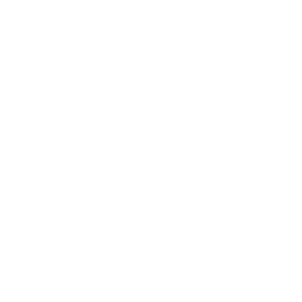

In [50]:
save_path = os.getcwd()
write_all_output(deactivate_linkage, io.SUBDIVISION_RESOLUTION, io.MODEL_NAME + '_deactivated', io.RIBBON_NAME + '_deactivated', False, 100, min(io.RIBBON_CS), target_width = 5, flip_angles = False, width = max(io.RIBBON_CS))
os.chdir(save_path)

In [34]:
# vf = show_selected_joints(deactivate_linkage_7, [deactive_vertex_map_7[11], deactive_vertex_map_7[8]])

In [35]:
# deactivate_curved_linkage_view.update(vectorField = vf, scalarField = colors)

In [36]:
# deactivate_curved_linkage_view.show()

In [37]:
# deactivate_linkage_7.energy()